In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2
from lbxs4.simulations import LBSky
from lbxs4.simulations import S4Sky
import lbxs4.utils as utils
from lbxs4.config import DATDIR

In [3]:
dire = '/pscratch/sd/l/lonappan/LBxS4'
lb = LBSky(dire,512)

In [22]:
s4 = S4Sky()

In [5]:
s4.nilc_fsky

0.622194230556488

Text(0, 0.5, '$C_{\\ell}$')

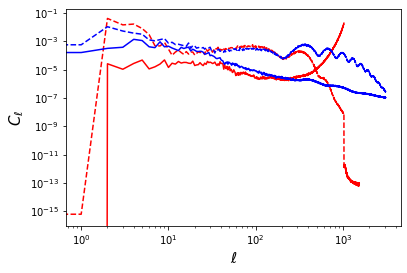

In [16]:
plt.loglog(lb.NILC_ncl(0),label='LB',c='r')
plt.loglog(hp.alm2cl(lb.NILC_Elm(0,False)),ls='--',label='LB',c='r')
plt.loglog(s4.NILC_ncl(0),label='S4',c='b')
plt.loglog(hp.alm2cl(s4.NILC_Elm(0)),ls='--',label='S4',c='b')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$C_{\ell}$',fontsize=15)

In [6]:
s4_elm = s4.NILC_Elm(0)

In [7]:
s4_qu = hp.alm2map_spin([s4_elm,s4_elm*0],1024,2,s4.lmax)

In [8]:
lb_elm = lb.NILC_Elm(0)

In [9]:
lb_qu = hp.alm2map_spin([lb_elm,lb_elm*0],512,2,lb.lmax)

In [10]:
ro_s4_qu = utils.change_coord(np.array(s4_qu),['C','G'])

In [11]:
ro_s4_mask = utils.change_coord(s4.mask,['C','G'])

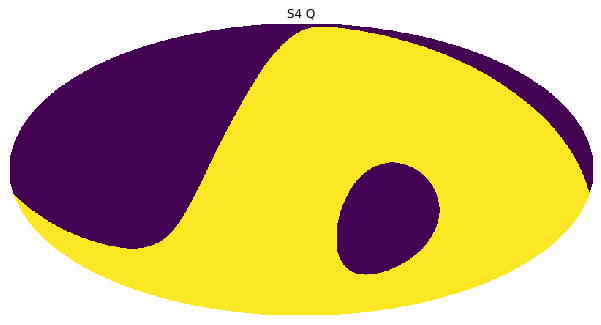

In [23]:
hp.mollview(s4.nilc_mask,title='S4 Q',cbar=False)

In [12]:
import curvedsky as cs
import cmb

In [13]:
Tcmb = 2.726e6

In [14]:
cl_len = cmb.read_camb_cls(os.path.join(DATDIR,'FFP10_wdipole_lensedCls.dat'),ftype='lens',output='array')

In [15]:
lb_Bl = np.reshape(lb.beam,(1,lb.lmax+1))
lb_ninv = np.reshape(np.array((lb.nilc_mask,lb.nilc_mask)),(2,1,hp.nside2npix(lb.nside)))
lb_QU = np.reshape(np.array((lb_qu[0]*lb.nilc_mask,lb_qu[1]*lb.nilc_mask)),
                            (2,1,hp.nside2npix(lb.nside)))/Tcmb
lb_ne = lb.NILC_ncl(0)
if len(lb_ne) < lb.lmax+1:
    lb_ne = np.append(lb_ne,np.zeros(lb.lmax+1-len(lb_ne)))
lb_ne = lb_ne/Tcmb**2
lb_NL = np.reshape(np.array((utils.cli(lb_ne[:lb.lmax+1]), utils.cli(lb_ne[:lb.lmax+1]*0))),(2,1,lb.lmax+1))

In [17]:
#LB
lb_E,lb_B = cs.cninv.cnfilter_freq(2,1,lb.nside,lb.lmax,cl_len[1:3,:lb.lmax+1],lb_Bl, lb_ninv,lb_QU,chn=1,itns=[1000],filter="W",
                                        eps=[1e-5],ro=10,inl=lb_NL,stat='stat.txt')


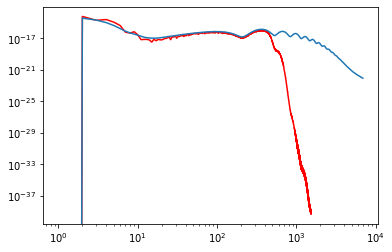

In [19]:
plt.loglog(cs.utils.alm2cl(lb.lmax,lb_E),label='LB',c='r')
plt.loglog(cl_len[1,:])


In [24]:
s4_Bl = np.reshape(s4.beam,(1,s4.lmax+1))
s4_ninv = np.reshape(np.array((s4.nilc_mask,s4.nilc_mask)),(2,1,hp.nside2npix(s4.nside)))
s4_QU = np.reshape(np.array((ro_s4_qu[0]*s4.nilc_mask,ro_s4_qu[1]*s4.nilc_mask)),
                            (2,1,hp.nside2npix(s4.nside)))/Tcmb
s4_ne = s4.NILC_ncl(0)
if len(s4_ne) < s4.lmax+1:
    s4_ne = np.append(s4_ne,np.zeros(s4.lmax+1-len(s4_ne)))
s4_ne = s4_ne/Tcmb**2
s4_NL = np.reshape(np.array((utils.cli(s4_ne[:s4.lmax+1]), utils.cli(s4_ne[:s4.lmax+1]*0))),(2,1,s4.lmax+1))

In [25]:
s4_E,s4_B = cs.cninv.cnfilter_freq(2,1,s4.nside,s4.lmax,cl_len[1:3,:s4.lmax+1],s4_Bl, s4_ninv,s4_QU,chn=1,itns=[1000],filter="W",
                                        eps=[1e-5],ro=10,inl=s4_NL,stat='stat.txt')